In [1]:
import numpy as np
import os
# import PIL
# import PIL.Image
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
import tensorflow_datasets as tfds
from functools import partial
import pathlib # is it used?
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300

In [4]:
def plotImage(image, cmap=None, title=None):
    plt.figure()
    if cmap != None:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
    if title != None:
        plt.title(title)
    plt.show()

In [5]:
def visualize(original, augmented):
    
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.show()

In [6]:
def predictionsToText(pred, sep=None):
    txt = ""
#     print(pred)
    for i in pred:
#         print(i)
        txt = f"{txt}{i:.4f} "
    txt = txt.strip()
    if sep != None:
        txt = txt.replace(" ", sep)
    return txt

In [7]:
batch_size = 17
# batch_size = 20
img_height = 740
img_width = 596
slice_size = 60
learning_rate=1e-4
epochs = 68
drop_rate = 0.33

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
def load_labels(data):
    file_name = tf.strings.split(data, sep="/")[-1]
    label1 = tf.strings.split(file_name, sep="_")[0]
    label2 = tf.strings.split(file_name, sep="_")[1]
    label3 = tf.strings.split(file_name, sep="_")[2]
    label4 = tf.strings.split(file_name, sep="_")[3]
    label5 = tf.strings.split(file_name, sep="_")[4]
    label6 = tf.strings.split(file_name, sep="_")[5]
    out1 = 1 if label1 == '1' else 0
    out2 = 1 if label2 == '1' else 0
    out3 = 1 if label3 == '1' else 0
    out4 = 1 if label4 == '1' else 0
    out5 = 1 if label5 == '1' else 0
    out6 = 1 if label6 == '1' else 0
    # think about vehicle sum
#     outa0 = 1 if out1 + out2 + out3 == 0 else 0 #no masks present (Carlefts)
#     outa1 = 1 if out1 + out2 + out3 == 1 else 0 #present 1 mask
#     outa2 = 1 if out1 + out2 + out3 == 2 else 0 #present 2 masks
#     outa3 = 1 if out1 + out2 + out3 == 3 else 0 #present 3 masks
    
#     outb0 = 1 if out4 + out5 + out6 == 0 else 0
#     outb1 = 1 if out4 + out5 + out6 == 1 else 0
#     outb2 = 1 if out4 + out5 + out6 == 2 else 0
#     outb3 = 1 if out4 + out5 + out6 == 3 else 0
    
    
    outa0 = 1 if out1 + out2 == 2 else 0 # bus left
    outa1 = 1 if out1 + out3 == 2 else 0 # car left
#     outa2 = 1 if out1 + out2 + out3 == 2 else 0 #present 2 masks
#     outa3 = 1 if out1 + out2 + out3 == 3 else 0 #present 3 masks 
    outb0 = 1 if out4 + out5 == 2 else 0 # bus right
    outb1 = 1 if out4 + out6 == 2 else 0 # car right
#     outb2 = 1 if out4 + out5 + out6 == 2 else 0
#     outb3 = 1 if out4 + out5 + out6 == 3 else 0
    
    
    outa0 = tf.cast(outa0, dtype=tf.float32) #converting values into float
    outa1 = tf.cast(outa1, dtype=tf.float32)
#     outa2 = tf.cast(outa2, dtype=tf.float32)
#     outa3 = tf.cast(outa3, dtype=tf.float32)
    outb0 = tf.cast(outb0, dtype=tf.float32)
    outb1 = tf.cast(outb1, dtype=tf.float32)
#     outb2 = tf.cast(outb2, dtype=tf.float32)
#     outb3 = tf.cast(outb3, dtype=tf.float32)
#     out6 = tf.cast(out6, dtype=tf.float32)

    image = tf.io.read_file(data)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, dtype=tf.float32)
    #division is done whether goes left or right
    return (image/255., ([outa0, outa1, outb0, outb1]))

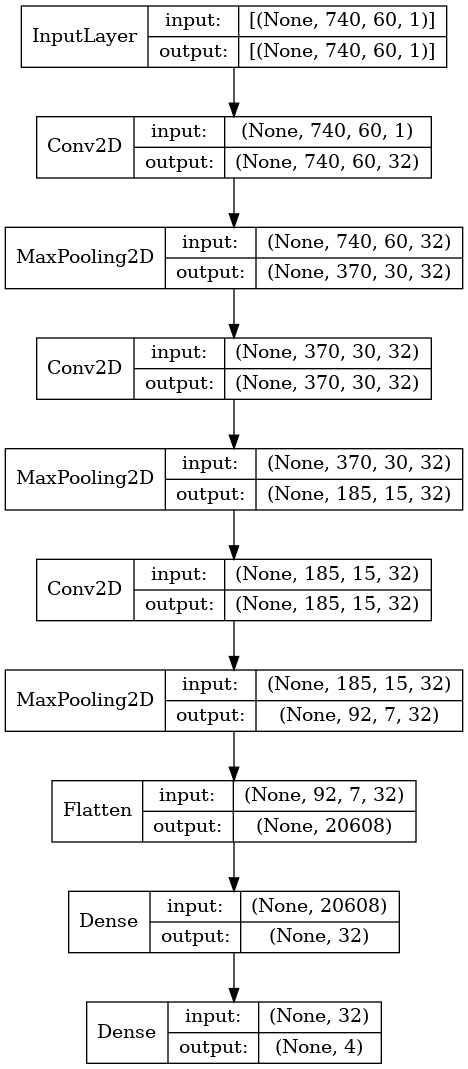

In [10]:
input_layer = tf.keras.layers.Input(shape=(740, slice_size, 1,))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(input_layer)
# Try valid padding
x = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(input_layer)#(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)

# x = tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)

# x = tf.keras.layers.Conv2D(512, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)

# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)

#make 6 layers here(x)
x1 = tf.keras.layers.Dense(4, activation='softmax')(x) # 4
# x2 = tf.keras.layers.Dense(2, activation='softmax')(x) # 4

# x3 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# x4 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# x5 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# x6 = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=input_layer, outputs=[x1])
# model = tf.keras.Model(inputs=input_layer, outputs=[x1, x2, x3, x4, x5, x6])

dot_img_file = '/tf/train_py/Architecture_plots/beseline_model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_layer_names=False, show_shapes=True)


In [11]:
tf.random.set_seed(43)
# counter = tf.data.experimental.Counter()
# seeds
#Augmentation
# seed_aug_0 = tf.data.Dataset.from_tensor_slices([10])
# seed_aug_0 = seed_aug_0.repeat(10000000)
# seed_aug_1 = tf.data.Dataset.from_tensor_slices([25])
# seed_aug_1 = seed_aug_1.repeat(10000000)
# seed_aug_2 = tf.data.Dataset.from_tensor_slices([59])
# seed_aug_2 = seed_aug_2.repeat(10000000)


ds_names_o = tf.data.Dataset.list_files(str('./veh_types/train/*.png'), shuffle=False).batch(batch_size)
ds_training_ = tf.data.Dataset.list_files(str('./veh_types/train/*.png'), shuffle=False)
# ds_training = (ds_training
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_training_15 = tf.data.Dataset.list_files(str('./images_split_15/*.png'), shuffle=False)
# ds_training_15 = (ds_training_15
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_training_30 = tf.data.Dataset.list_files(str('./images_split_30/*.png'), shuffle=False)
# ds_training_30 = (ds_training_30
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_training_45 = tf.data.Dataset.list_files(str('./images_split_45/*.png'), shuffle=False)
# ds_training_45 = (ds_training_45
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_synth = tf.data.Dataset.list_files(str('./images_synth/*.png'), shuffle=False)
# ds_training_45 = (ds_training_45
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )

# ds_training = ds_training_.concatenate(ds_training_15).concatenate(ds_training_30).concatenate(ds_training_45).concatenate(ds_synth) #names
# ds_training_aug = ds_training
ds_training = ds_training_
# Augmentation
# ds_training_aug = tf.data.Dataset.zip((ds_training, (seed_aug_0, seed_aug_0)))
# ds_training_aug_1 = tf.data.Dataset.zip((ds_training, (seed_aug_1, seed_aug_1)))
# ds_training_aug_2 = tf.data.Dataset.zip((ds_training, (seed_aug_2, seed_aug_2)))

ds_training = (ds_training
  .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
  .cache()
  # .repeat()
  .batch(batch_size)
  .prefetch(AUTOTUNE)
)
#Augmentation
# ds_training_aug = (ds_training_aug
#   .shuffle(180, seed=43)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_training_aug_1 = (ds_training_aug_1
#   .shuffle(180, seed=43)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_training_aug_2 = (ds_training_aug_2
#   .shuffle(180, seed=43)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_synth = (ds_synth
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )

# ds_training = ds_training.concatenate(ds_training_aug).concatenate(ds_training_aug_1).concatenate(ds_training_aug_2)
#.concatenate(ds_synth)

ds_val = tf.data.Dataset.list_files(str('./veh_types/val/*.png')) #names
# ds_val_aug = ds_val
# Augmentation
# ds_val_aug = tf.data.Dataset.zip((ds_val, (seed_aug_0, seed_aug_0)))
# ds_val_aug_1 = tf.data.Dataset.zip((ds_val, (seed_aug_1, seed_aug_1)))
# ds_val_aug_2 = tf.data.Dataset.zip((ds_val, (seed_aug_2, seed_aug_2)))

ds_val = (ds_val
  .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
  .cache()
  # .repeat()
  .batch(batch_size)
  .prefetch(AUTOTUNE)
)
# ds_val_aug = (ds_val_aug
# #   .shuffle(180, seed=3343)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_val_aug_1 = (ds_val_aug_1
# #   .shuffle(180, seed=3343)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_val_aug_2 = (ds_val_aug_2
# #   .shuffle(180, seed=3343)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_val = ds_val.concatenate(ds_val_aug).concatenate(ds_val_aug_1).concatenate(ds_val_aug_2)

ds_test = tf.data.Dataset.list_files(str('./veh_types/test/*.png'), shuffle=False)
ds_test = (ds_test
  .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
  .cache()
  # .repeat()
  .batch(batch_size)
  .prefetch(AUTOTUNE)
)

ds_test_names_o = tf.data.Dataset.list_files(str('./veh_types/test/*.png'), shuffle=False).batch(100)
# .batch(batch_size)
ds_test_o = tf.data.Dataset.list_files(str('./veh_types/test/*.png'), shuffle=False)
ds_test_o = (ds_test_o
#   .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   .repeat()
#   .batch(batch_size)
  .batch(100)
#   .prefetch(AUTOTUNE)
)


In [12]:
# Check label values
it1 = iter(ds_test)
a = [1., 0., 0., 0.]
z = np.round(a,0)

for i in np.arange(len(ds_test)):
    img, labels = next(it1)
    y1 = labels
    b = y1.numpy().shape[0]
#     predictions_test = model.predict(img)
#     PlotDataset(y1,y2)
    print("label shape", y1.shape)
    for elem in y1:
        if not (np.array_equal(elem, z)):
            print(((elem).numpy()))
#     for i in np.arange(b):
#         p1, p2 = predictions_test
#         current_name = batch_names[i].numpy().decode("UTF-8")
#         current_img = cv2.imread(current_name, cv2.IMREAD_COLOR)
#         current_img = cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB)
#         plotImage(current_img, title=os.path.basename(current_name))

label shape (8, 4)
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 1. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 1. 0.]
[0. 1. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 1. 0.]


In [13]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),#'adam',
  loss=[tf.losses.CategoricalCrossentropy(label_smoothing=0.0),tf.losses.CategoricalCrossentropy(label_smoothing=0.0)],
#   loss=[tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy()],
  # loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])
  # metrics=[tf.keras.losses.mean_absolute_error, "accuracy"])

In [14]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 740, 60, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 740, 60, 32)       832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 370, 30, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 370, 30, 32)       25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 185, 15, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 185, 15, 32)       25632 

In [15]:
history = model.fit(
  ds_training,
  validation_data=ds_val,
  epochs=100
)

Epoch 1/100
4/4 [==============================] - 4s 164ms/step - loss: 1.4082 - accuracy: 0.2353 - val_loss: 1.4117 - val_accuracy: 0.2500
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 1.3768 - accuracy: 0.3088 - val_loss: 1.4056 - val_accuracy: 0.2500
Epoch 3/100
4/4 [==============================] - 0s 25ms/step - loss: 1.3707 - accuracy: 0.3088 - val_loss: 1.3987 - val_accuracy: 0.2500
Epoch 4/100
4/4 [==============================] - 0s 25ms/step - loss: 1.3691 - accuracy: 0.3088 - val_loss: 1.3954 - val_accuracy: 0.2500
Epoch 5/100
4/4 [==============================] - 0s 25ms/step - loss: 1.3688 - accuracy: 0.3088 - val_loss: 1.3947 - val_accuracy: 0.2500
Epoch 6/100
4/4 [==============================] - 0s 25ms/step - loss: 1.3683 - accuracy: 0.3088 - val_loss: 1.3952 - val_accuracy: 0.2500
Epoch 7/100
4/4 [==============================] - 0s 25ms/step - loss: 1.3674 - accuracy: 0.3088 - val_loss: 1.3962 - val_accuracy: 0.2500
Epoch 8/100
4/4 [==

4/4 [==============================] - 0s 25ms/step - loss: 0.9562 - accuracy: 0.5882 - val_loss: 1.1344 - val_accuracy: 0.6250
Epoch 60/100
4/4 [==============================] - 0s 25ms/step - loss: 1.0287 - accuracy: 0.4706 - val_loss: 1.1470 - val_accuracy: 0.3750
Epoch 61/100
4/4 [==============================] - 0s 25ms/step - loss: 0.9253 - accuracy: 0.6471 - val_loss: 1.1073 - val_accuracy: 0.6250
Epoch 62/100
4/4 [==============================] - 0s 30ms/step - loss: 1.0162 - accuracy: 0.5000 - val_loss: 1.1147 - val_accuracy: 0.5000
Epoch 63/100
4/4 [==============================] - 0s 26ms/step - loss: 0.9104 - accuracy: 0.6176 - val_loss: 0.9974 - val_accuracy: 0.6250
Epoch 64/100
4/4 [==============================] - 0s 25ms/step - loss: 0.9569 - accuracy: 0.5294 - val_loss: 0.9759 - val_accuracy: 0.3750
Epoch 65/100
4/4 [==============================] - 0s 25ms/step - loss: 0.8543 - accuracy: 0.7059 - val_loss: 0.8698 - val_accuracy: 0.6250
Epoch 66/100
4/4 [========

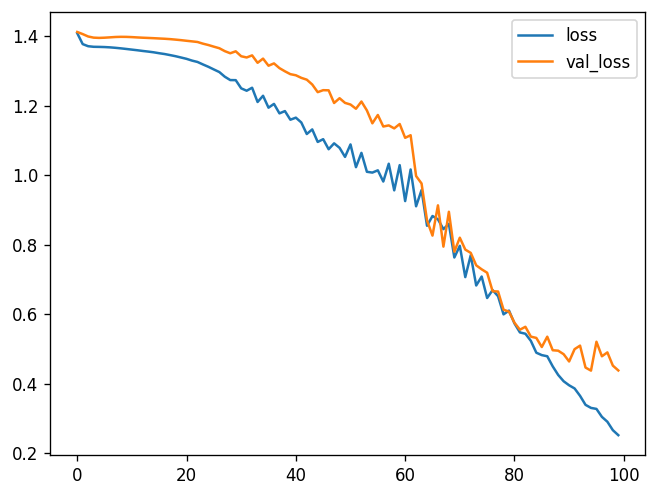

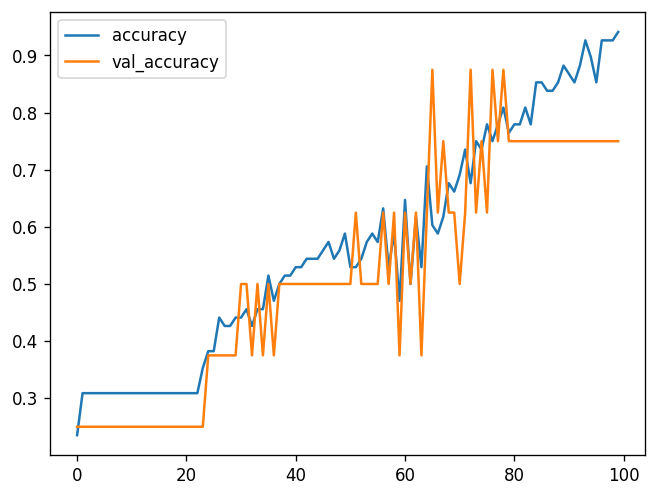

1/1 [==============================] - 0s 12ms/step - loss: 0.9194 - accuracy: 0.5000
[0.9194098114967346, 0.5]


In [16]:
metrics2 = history.history
plt.plot(history.epoch, metrics2['loss'], metrics2['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
# print(model.evaluate(ds_test))
plt.plot(history.epoch, metrics2['accuracy'], metrics2['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
# print(model.evaluate(ds_test))
# plt.plot(history.epoch, metrics2['dense_2_accuracy'], metrics2['val_dense_2_accuracy'])
# plt.legend(['accuracy', 'val_accuracy'])
# plt.show()
print(model.evaluate(ds_test))

In [17]:
predictions = model.predict(ds_test)

1/1 [==============================] - 0s 70ms/step


In [18]:
p1 = predictions
# p1, p2, p3, p4, p5, p6 = predictions

In [19]:
# predictions converted in human readable format
k = 1
for i in np.arange(p1.shape[0]):
    txt = "["
    txt = f"{txt} {predictionsToText(p1[i])}"
#     for j in p1[i]:
#         txt = f"{txt} {j:.4f}"
#     txt = f"{txt} ::"
#     txt = f"{txt} {predictionsToText(p2[i])}"
#     for j in p2[i]:
#         txt = f"{txt} {j:.4f}"
    txt = f"{k:04d}: {txt} ]"
    k = k + 1
    print(txt)

0001: [ 0.2758 0.1907 0.3778 0.1558 ]
0002: [ 0.0493 0.0039 0.9424 0.0044 ]
0003: [ 0.0076 0.6053 0.0200 0.3670 ]
0004: [ 0.0055 0.7306 0.0151 0.2488 ]
0005: [ 0.1749 0.1372 0.4656 0.2223 ]
0006: [ 0.0043 0.8317 0.0119 0.1521 ]
0007: [ 0.0084 0.7833 0.0202 0.1882 ]
0008: [ 0.2006 0.0532 0.6719 0.0744 ]


In [20]:
def PlotDataset(ytrue1):
#     ytrue1 = ytrue1.numpy()
#     ytrue2 = ytrue2.numpy()
    #print(ytrue1)
    bar1 = np.zeros(4)
#     bar2 = np.zeros(2)
    #print(hist1)
    carlabels1 = ['Bus L', 'Car L', 'Bus R', 'Car R']
#     carlabels2 = ['None', '1Right']
    
    for i in range(len(ytrue1)):
        bar1 += ytrue1[i]
#         bar2 += ytrue2[i]
#     print(bar1)
#     print(bar2)
    
    plt.bar(carlabels1, bar1)
    plt.title("ds_test_o Bar Left")
    plt.show()
#     plt.bar(carlabels2, bar2)
#     plt.title("ds_test_o Bar Right")
#     plt.show()

In [21]:
a = np.random.rand(10,4)
print(a)
# z = np.zeros((10))
# print(z)
print('____________')
for num in a:
    z = np.zeros((4))
    a_max_i = np.argmax(num)
#     print(a_max_i)
    z[a_max_i] = 1
    print(z)
#     print(z[a_max_i])

[[0.10457008 0.12654029 0.75010076 0.59599927]
 [0.2111319  0.45980347 0.32120486 0.65294598]
 [0.94008041 0.45779723 0.53077857 0.60078519]
 [0.71847854 0.42801428 0.29359639 0.03156522]
 [0.8322887  0.7811054  0.86813747 0.90708777]
 [0.22623634 0.09575457 0.97814108 0.05005405]
 [0.36493226 0.62371818 0.25863729 0.86204251]
 [0.3004631  0.53716849 0.92288969 0.94172225]
 [0.81951848 0.35047196 0.0502935  0.03444682]
 [0.2162352  0.52108952 0.33401917 0.3692388 ]]
____________
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0. 1. 0. 0.]


In [22]:
def ConfusionMatrix(pred1, ytrue1):
    #print(tf.reshape(ytrue, [-1]))
    
#     ytrue1 = ytrue1.numpy()
#     ytrue2 = ytrue2.numpy()
#     pred1 = (np.round(pred1, 0))
#     pred2 = (np.round(pred2, 0))
    predictions1 = pred1
#     predictions2 = pred2
    pred1 = []
#     pred2 = []
    
#     for i,pred in enumerate(predictions1):
#         a = np.where(pred == np.max(pred), 1, 0)
#         pred1.append(a)
        
#     for i,pred in enumerate(predictions2):
#         a = np.where(pred == np.max(pred), 1, 0)
#         pred2.append(a)
        
    for num in predictions1:
        z = np.zeros((4))
        predictions1_max_i = np.argmax(num)
#         print(predictions1_max_i)
        z[predictions1_max_i] = 1
        pred1.append(z)
        
#     for num in predictions2:
#         z = np.zeros((2))
#         predictions2_max_i = np.argmax(num)
#         z[predictions2_max_i] = 1
#         pred2.append(z)

    
    #print(pred, pred.shape)
    #print((pred.flatten()))

    #print(pred.flatten()) #tf.reshape(ytrue, [-1])
    #ARRAYS OF 1s AND 0s HAVE TO BE TRANSLATED INTO LABELS
    
    #print(len(ytrue1))
    #print(len(pred1))
    conf_matrix1 = np.zeros((4,4))
    conf_matrix2 = np.zeros((2,2))
    conf_matrix3 = np.zeros((2,2))
    conf_matrix4 = np.zeros((2,2))
    #print(conf_matrix1)

    for i in range(len(ytrue1)):
        #print(ytrue[i])
        #print(pred[i])
        mat11 = ytrue1[i] #labels left
        mat11 = mat11.reshape(4,1)
        mat12 = pred1[i] #predictions left
        mat12 = mat12.reshape(1,4)
#         mat21 = ytrue2[i] #labels right
#         mat21 = mat21.reshape(4,1)
#         mat22 = pred2[i] #predictions right
#         mat22 = mat22.reshape(1,4)
        #print(mat1)
        #print(mat2)
                
        conf_matrix1 += np.dot(mat11, mat12) #L2L
#         conf_matrix2 += np.dot(mat11, mat22) #L2R
#         conf_matrix3 += np.dot(mat21, mat12) #R2L
#         conf_matrix4 += np.dot(mat21, mat22) #R2R
    #print(conf_matrix1.shape)
    #print(conf_matrix1)
    #print(conf_matrix2.shape)
    #print(conf_matrix2)
    
#     confusion_mtx = tf.math.confusion_matrix(ytrue.flatten(), pred.flatten(), num_classes=8, dtype=tf.dtypes.float32,) #, num_classes=8
#     #print(confusion_mtx)
    carlabels1 = ['Bus L', 'Car L', 'Bus R', 'Car R']
#     carlabels2 = ['None', '1Right']#, '2Right', '3Right']
    #fig, axs = plt.subplots(2, 2)
    
    sns.heatmap(conf_matrix1, xticklabels=carlabels1, yticklabels=carlabels1, 
            annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
#     sns.heatmap(conf_matrix4, xticklabels=carlabels2, yticklabels=carlabels2, 
#             annot=True, fmt='g')
#     plt.xlabel('Prediction')
#     plt.ylabel('Label')
#     plt.show()
# #     sns.heatmap(conf_matrix2, xticklabels=carlabels2, yticklabels=carlabels2, 
#             annot=True, fmt='g')
#     plt.xlabel('Prediction')
#     plt.ylabel('Label')
# #     plt.show()
    

#     fig,axn = plt.subplots(2, 2, sharex=True, sharey=True)
#     cbar_ax = fig.add_axes([.91, .3, .03, .4])
    
#     conf_matrixes = [conf_matrix1, conf_matrix2, conf_matrix3, conf_matrix4]
#     itr = iter(conf_matrixes)
#     for ax in axn.flat:
#         sns.heatmap(next(itr), xticklabels=carlabels1, yticklabels=carlabels1, 
#                 annot=True, fmt='g', ax=ax)
#         plt.xlabel('Prediction')
#         plt.ylabel('Label')
#     plt.show()
    
#     for i, ax in enumerate(axn.flat):
#         sns.heatmap(next(itr), xticklabels=carlabels2, yticklabels=carlabels1, 
#                     annot=True, fmt='g', ax=ax,
#                     cbar=i == 0,
#                     #vmin=0, vmax=1,
#                     cbar_ax=None if i else cbar_ax)

# #     fig.tight_layout(rect=[0, 0, 1, 1])
#     plt.xlabel('Prediction')
#     plt.ylabel('Label')
#     plt.show()
    
#     for i, matrix in enumerate(conf_matrixes):
#         if i == 0:
#             print("Left to Left")
#         if i == 1:
#             print("Left to Right")
#         if i == 2:
#             print("Right to Left")
#         if i == 3:
#             print("Right to Right")
    matrix = conf_matrix1
    row0sum = np.sum(matrix[0])
    row1sum = np.sum(matrix[1])
    row2sum = np.sum(matrix[2])
    row3sum = np.sum(matrix[3])
    col0sum = np.sum(matrix[:,0])
    col1sum = np.sum(matrix[:,1])
    col2sum = np.sum(matrix[:,2])    
    col3sum = np.sum(matrix[:,3])
        
    d0 = matrix[0,0]
    d1 = matrix[1,1]
    d2 = matrix[2,2]
    d3 = matrix[3,3]
        
    precision0 = round((100*d0/row0sum),2)
    precision1 = round((100*d1/row1sum),2)
    precision2 = round((100*d2/row2sum),2)
    precision3 = round((100*d3/row3sum),2)
    recall0 = round((100*d0/col0sum),2)
    recall1 = round((100*d1/col1sum),2)
    recall2 = round((100*d2/col2sum),2)
    recall3 = round((100*d3/col3sum),2)
        
    print("PRECISIONS:",'\t',"None - ", precision0, " 1 Car - ", precision1, " 2 Car - ", precision2, " 3 Car - ", precision3)
    print("RECALLS:",'\t',"None - ", recall0, " 1 Car - ", recall1, " 2 Car - ", recall2, " 3 Car - ", recall3)
#         print("row 0", matrix[0], row0sum, d0, d1, d2, d3)
#         print("column 0", matrix[:,0], col0sum)
    plt.show()

In [23]:
# Count pitcures in test dataset
sum = 0
test_names_arr = tfds.as_numpy(ds_test_names_o)
print(len(test_names_arr))
for num in test_names_arr:
    print(len(num))
    sum += len(num)
print(sum)

1
8
8


1/1 [==============================] - 0s 59ms/step


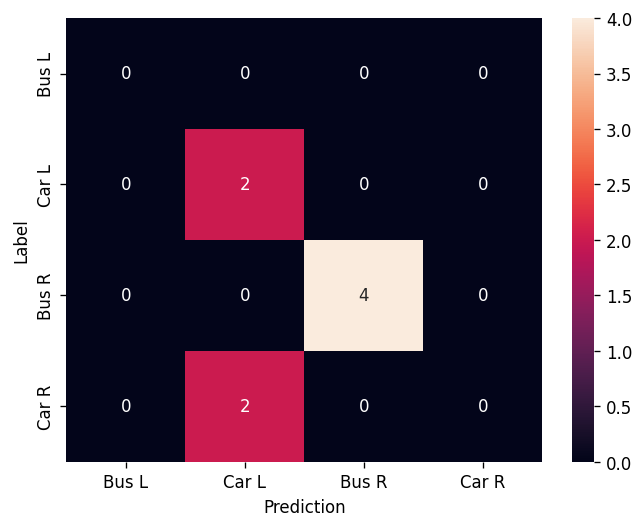

PRECISIONS: 	 None -  nan  1 Car -  100.0  2 Car -  100.0  3 Car -  0.0
RECALLS: 	 None -  nan  1 Car -  50.0  2 Car -  100.0  3 Car -  nan


<ipython-input-22-0439960a1add>:143: RuntimeWarning: invalid value encountered in double_scalars
  precision0 = round((100*d0/row0sum),2)
<ipython-input-22-0439960a1add>:147: RuntimeWarning: invalid value encountered in double_scalars
  recall0 = round((100*d0/col0sum),2)
<ipython-input-22-0439960a1add>:150: RuntimeWarning: invalid value encountered in double_scalars
  recall3 = round((100*d3/col3sum),2)


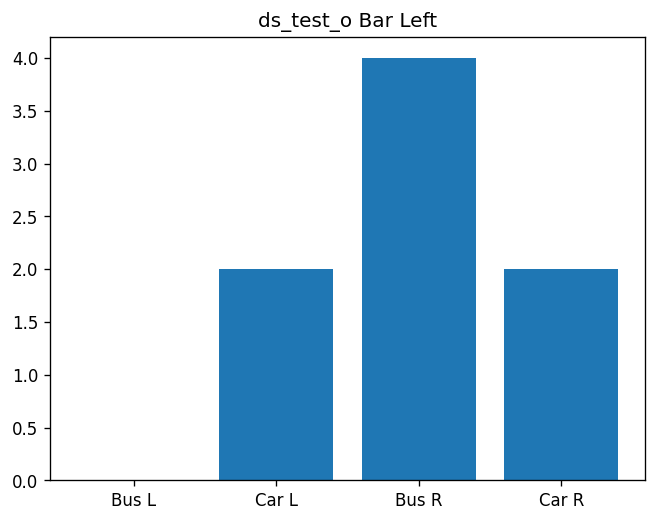

In [24]:
# print(p1.shape)
it1 = iter(ds_test_o)
it2 = iter(ds_test_names_o)
p1total = list()
p2total = list()
y1total = list()
y2total = list()

# for i in np.arange(13):
for i in np.arange(len(tfds.as_numpy(ds_test_names_o))):
    img, labels = next(it1)
    batch_names = next(it2)
    predictions_test = model.predict(img)
    p1 = predictions_test
    y1 = labels
    if i == 0:
        y1total = y1.numpy()
        p1total = p1
#         y2total = y2.numpy()
#         p2total = p2
    else:
        y1total = np.concatenate((y1total, y1.numpy()))
#         y2total = np.concatenate((y2total, y2.numpy()))
        p1total = np.concatenate((p1total, p1))
#         p2total = np.concatenate((p2total, p2))
#     PlotDataset(y1,y2)
# print((np.array(y1total)).shape)
# print((np.array(p1total)).shape)
ConfusionMatrix(p1total, y1total)
PlotDataset(y1total)
    #print(np.shape(predictions))
    #print(np.shape(labels))

1/1 [==============================] - 0s 20ms/step


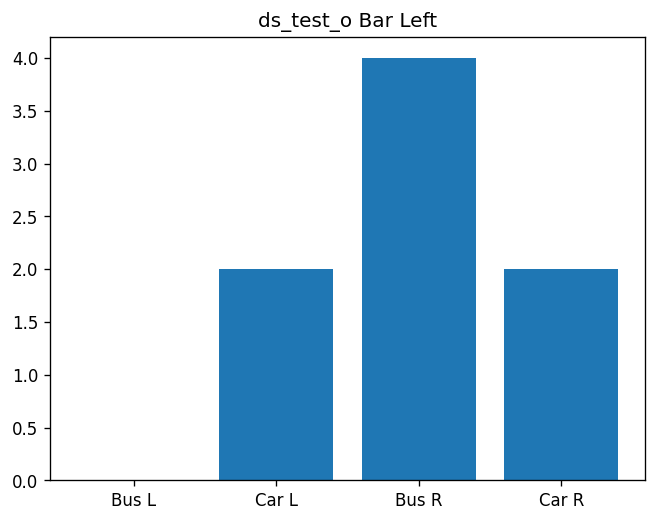

Labels:  [0. 0. 0. 1.]
Predictions:  [0. 1. 0. 0.]


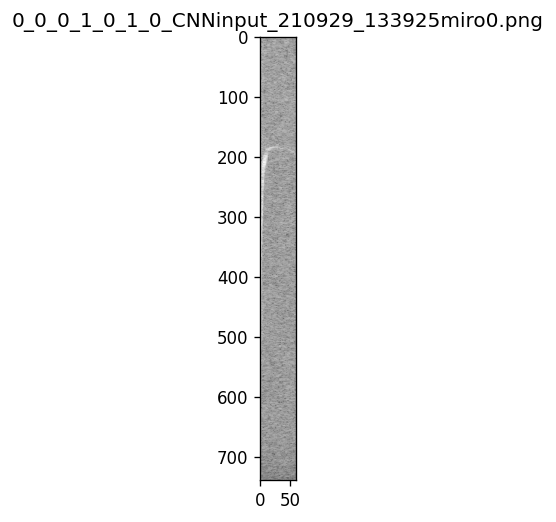

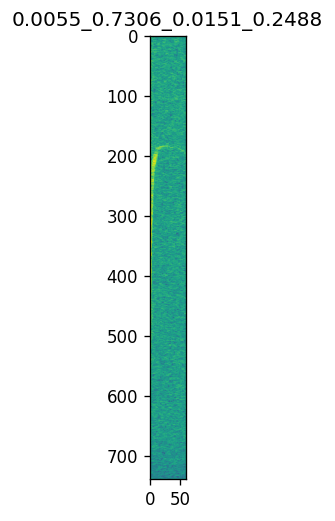

Labels:  [0. 0. 0. 1.]
Predictions:  [0. 1. 0. 0.]


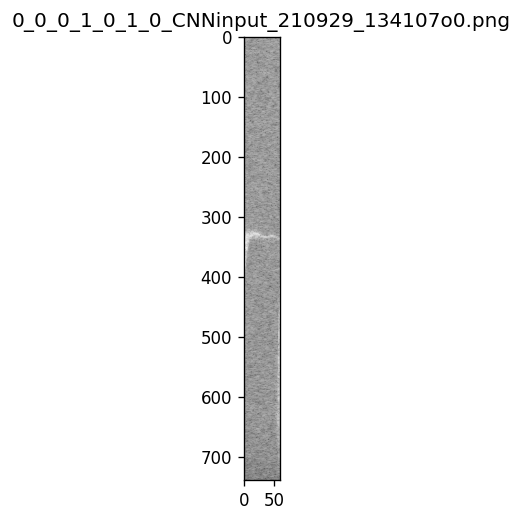

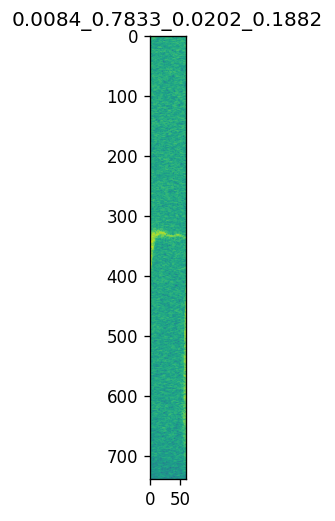

StopIteration: 

In [29]:
it1 = iter(ds_test_o)
it2 = iter(ds_test_names_o)

for i in np.arange(8):
    img, labels = next(it1)
    batch_names = next(it2)
    y1 = labels
    b = y1.numpy().shape[0]
    predictions_test = model.predict(img)
    PlotDataset(y1)
    for i in np.arange(b):
        p1 = predictions_test
        current_name = batch_names[i].numpy().decode("UTF-8")
        current_img = cv2.imread(current_name, cv2.IMREAD_COLOR)
        current_img = cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB)

        z1 = np.zeros((4))
        predictions2_max_i = np.argmax(p1[i])
        z1[predictions2_max_i] = 1
#         z2 = np.zeros((2))
#         predictions2_max_i = np.argmax(p2[i])
#         z2[predictions2_max_i] = 1
        
        if np.any(np.not_equal(y1[i], z1)):
            print("Labels: ", np.array(y1[i]))
            print("Predictions: ", z1)
            plotImage(current_img, title=os.path.basename(current_name))
            plotImage(img[i].numpy(), title=f"{predictionsToText(p1[i], sep='_')}")
#         plotImage(img[i].numpy(), title=f"{p1[i]}_{p2[i]}_{p3[i]}_{p4[i]}_{p5[i]}_{p6[i]}")
#         plotImage(img[i].numpy(), title=f"{y1[i].numpy().astype(np.uint8)}_{y2[i].numpy().astype(np.uint8)}_{y3[i].numpy().astype(np.uint8)}_{y4[i].numpy().astype(np.uint8)}_{y5[i].numpy().astype(np.uint8)}_{y6[i].numpy().astype(np.uint8)}")